In [15]:
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd

from Graph_Features import GraphSpec, build_structured_features

# Note:  I took the original RandomWalk_MC.ipynb file and copied it onto a Python file to be able to import it here the code is the same 
from RandomWalk_MC_Pyfile import build_lattice, run_simulation, average_trajectories



# Data Collection Script

In [16]:
LATTICE_TYPES = ("SC", "BCC", "FCC", "diamond")


def run_all_lattices_and_save_summaries(
    out_dir="summaries",
    n_runs=3,
    size=10,
    prob=0.06,
    diluted=True,
    nearest_neighbor=True,
    A=1.0,
    alpha=6.0,
    t_max=150,
    n_trajectories=20,
    n_configs=1,
    base_seed=123
):
    os.makedirs(out_dir, exist_ok=True)

    prob_map = {
        "SC": 0.35,
        "BCC": 0.20,
        "FCC": 0.20,
        "diamond": 0.60
    }

    for lattice_type in ("SC", "BCC", "FCC", "diamond"):
        prob_used = prob_map.get(lattice_type, prob)
        per_run = []

        r = 0
        attempt = 0
        while r < n_runs:
            attempt += 1
            np.random.seed(base_seed + 1000*attempt)

            results = run_simulation(
                size=size,
                a=1.0,
                lattice_type=lattice_type,
                diluted=diluted,
                prob=prob_used,
                nearest_neighbor=nearest_neighbor,
                A=A,
                alpha=alpha,
                t_max=t_max,
                n_trajectories=n_trajectories,
                n_configs=n_configs,
                savefile=None
            )

            msd_vs_steps, msd_vs_time, t_bins, distinct_sites_vs_steps = average_trajectories(results, t_max)

            # skip dead/near-dead runs
            if len(t_bins) <= 5 or t_bins[-1] == 0.0:
                print(f"Skipping dead run: {lattice_type} attempt{attempt} (prob={prob_used})")
                continue

            per_run.append((msd_vs_steps, msd_vs_time, t_bins, distinct_sites_vs_steps))

            np.savez(
                f"{out_dir}/rw_summary_{lattice_type}_run{r:02d}.npz",
                msd_vs_steps=msd_vs_steps,
                msd_vs_time=msd_vs_time,
                t_bins=t_bins,
                distinct_sites_vs_steps=distinct_sites_vs_steps,
                lattice=lattice_type,
                prob=prob_used,
                size=size
            )

            r += 1

        # --- average across runs with common-prefix trimming ---
        msd_steps_list = [x[0] for x in per_run]
        msd_time_list  = [x[1] for x in per_run]
        t_bins_list    = [x[2] for x in per_run]
        sites_list     = [x[3] for x in per_run]

        L_steps = min(len(a) for a in msd_steps_list)
        L_time  = min(len(a) for a in msd_time_list)
        L_sites = min(len(a) for a in sites_list)

        msd_steps_stack = np.vstack([a[:L_steps] for a in msd_steps_list])
        msd_time_stack  = np.vstack([a[:L_time] for a in msd_time_list])
        sites_stack     = np.vstack([a[:L_sites] for a in sites_list])

        t_bins_ref = t_bins_list[0][:L_time]

        msd_steps = np.mean(msd_steps_stack, axis=0)
        msd_time  = np.mean(msd_time_stack, axis=0)
        sites     = np.mean(sites_stack, axis=0)

        msd_steps_std = np.std(msd_steps_stack, axis=0, ddof=1) if n_runs > 1 else np.zeros(L_steps)
        msd_time_std  = np.std(msd_time_stack, axis=0, ddof=1)  if n_runs > 1 else np.zeros(L_time)
        sites_std     = np.std(sites_stack, axis=0, ddof=1)     if n_runs > 1 else np.zeros(L_sites)

        np.savez(
            f"{out_dir}/rw_summary_{lattice_type}_AVG.npz",
            msd_vs_steps=msd_steps,
            msd_vs_time=msd_time,
            t_bins=t_bins_ref,
            distinct_sites_vs_steps=sites,
            msd_vs_steps_std=msd_steps_std,
            msd_vs_time_std=msd_time_std,
            distinct_sites_vs_steps_std=sites_std,
            n_runs=n_runs,
            prob=prob_used,
            size=size,
            lattice=lattice_type
        )




# run_all_lattices_and_save_summaries(
#     out_dir="summaries_sub_2",
#     n_runs=5,
#     size=6,
#     diluted=True,
#     prob=0.2,          
#     nearest_neighbor=True,
#     A=1.0,
#     alpha=6.0,
#     t_max=150,
#     n_trajectories=20
# )

# Data Loading and Summarization

In [17]:
def load_runs_for_lattice(folder, lattice):
    paths = sorted(glob.glob(os.path.join(folder, f"rw_summary_{lattice}_run*.npz")))
    if len(paths) == 0:
        raise FileNotFoundError(f"No run files found for {lattice} in {folder}")

    runs = []
    for p in paths:
        d = np.load(p)
        runs.append({
            "msd_vs_steps": d["msd_vs_steps"],
            "msd_vs_time": d["msd_vs_time"],
            "t_bins": d["t_bins"],
            "distinct_sites_vs_steps": d["distinct_sites_vs_steps"],
        })
    return runs, paths

def stack_common_prefix(arr_list):
    """Stack arrays after trimming to the shortest length (common prefix)."""
    L = min(len(a) for a in arr_list)
    stacked = np.vstack([a[:L] for a in arr_list])
    return stacked

def summarize_lattice_runs(folder, lattice):
    runs, paths = load_runs_for_lattice(folder, lattice)

    msd_steps_stack = stack_common_prefix([r["msd_vs_steps"] for r in runs])
    msd_time_stack  = stack_common_prefix([r["msd_vs_time"] for r in runs])
    distinct_stack  = stack_common_prefix([r["distinct_sites_vs_steps"] for r in runs])

    # t_bins: also trim to the same length as msd_vs_time
    t_bins_ref = runs[0]["t_bins"][:msd_time_stack.shape[1]]

    summary = {
        "lattice": lattice,
        "n_runs": len(paths),

        "msd_vs_steps_mean": np.mean(msd_steps_stack, axis=0),
        "msd_vs_steps_std":  np.std(msd_steps_stack, axis=0, ddof=1) if len(paths) > 1 else np.zeros(msd_steps_stack.shape[1]),

        "msd_vs_time_mean": np.mean(msd_time_stack, axis=0),
        "msd_vs_time_std":  np.std(msd_time_stack, axis=0, ddof=1) if len(paths) > 1 else np.zeros(msd_time_stack.shape[1]),

        "distinct_mean": np.mean(distinct_stack, axis=0),
        "distinct_std":  np.std(distinct_stack, axis=0, ddof=1) if len(paths) > 1 else np.zeros(distinct_stack.shape[1]),

        "t_bins": t_bins_ref,
    }
    return summary


Sanity Checks

In [18]:
folder = "summaries_sub_2"
for lat in ["SC","BCC","FCC","diamond"]:
    paths = sorted(glob.glob(os.path.join(folder, f"rw_summary_{lat}_run*.npz")))
    print(lat, "n_files =", len(paths))
    if paths:
        d = np.load(paths[0])
        print(" keys:", d.files)
        print(" shapes:",
              d["t_bins"].shape,
              d["msd_vs_time"].shape,
              d["distinct_sites_vs_steps"].shape,
              d["msd_vs_steps"].shape)
        print(" finite check:",
              np.isfinite(d["t_bins"]).all(),
              np.isfinite(d["msd_vs_time"]).all())
        print(" first t, last t:", d["t_bins"][0], d["t_bins"][-1])
    print("-"*40)

SC n_files = 5
 keys: ['msd_vs_steps', 'msd_vs_time', 't_bins', 'distinct_sites_vs_steps', 'lattice', 'prob', 'size']
 shapes: (307,) (307,) (308,) (308,)
 finite check: True True
 first t, last t: 0.0 149.5114006514658
----------------------------------------
BCC n_files = 5
 keys: ['msd_vs_steps', 'msd_vs_time', 't_bins', 'distinct_sites_vs_steps', 'lattice', 'prob', 'size']
 shapes: (145,) (145,) (150,) (150,)
 finite check: True True
 first t, last t: 0.0 144.96644295302013
----------------------------------------
FCC n_files = 5
 keys: ['msd_vs_steps', 'msd_vs_time', 't_bins', 'distinct_sites_vs_steps', 'lattice', 'prob', 'size']
 shapes: (233,) (233,) (234,) (234,)
 finite check: True True
 first t, last t: 0.0 149.35622317596568
----------------------------------------
diamond n_files = 5
 keys: ['msd_vs_steps', 'msd_vs_time', 't_bins', 'distinct_sites_vs_steps', 'lattice', 'prob', 'size']
 shapes: (339,) (339,) (342,) (342,)
 finite check: True True
 first t, last t: 0.0 148.68

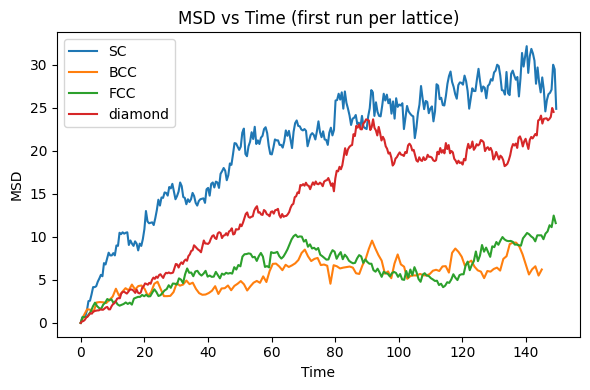

In [19]:
def load_first_run(folder, lat):
    paths = sorted(glob.glob(os.path.join(folder, f"rw_summary_{lat}_run*.npz")))
    return np.load(paths[0])

folder = "summaries_sub_2"
lattices = ["SC","BCC","FCC","diamond"]

plt.figure(figsize=(6,4))
for lat in lattices:
    d = load_first_run(folder, lat)
    t = d["t_bins"]
    y = d["msd_vs_time"]

    L = min(len(t), len(y))
    t = t[:L]
    y = y[:L]

    plt.plot(t, y, label=lat)

plt.xlabel("Time")
plt.ylabel("MSD")
plt.title("MSD vs Time (first run per lattice)")
plt.legend()
plt.tight_layout()
plt.show()

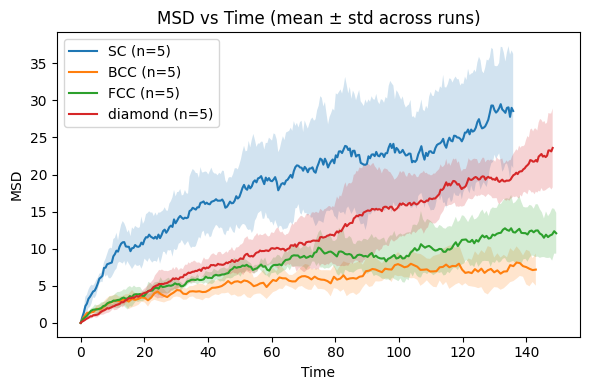

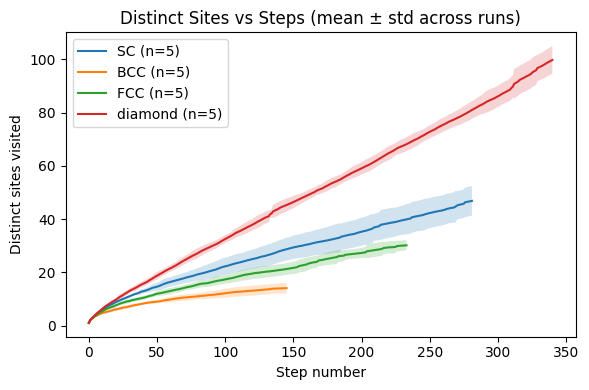

In [20]:
def summarize_runs(folder, lat):
    paths = sorted(glob.glob(os.path.join(folder, f"rw_summary_{lat}_run*.npz")))
    runs = [np.load(p) for p in paths]

    # Trimed to common length
    L_time = min(min(len(r["t_bins"]), len(r["msd_vs_time"])) for r in runs)
    L_steps = min(len(r["distinct_sites_vs_steps"]) for r in runs)

    t = runs[0]["t_bins"][:L_time]
    msd_stack = np.vstack([r["msd_vs_time"][:L_time] for r in runs])
    distinct_stack = np.vstack([r["distinct_sites_vs_steps"][:L_steps] for r in runs])

    return {
        "n": len(runs),
        "t": t,
        "msd_mean": msd_stack.mean(axis=0),
        "msd_std": msd_stack.std(axis=0, ddof=1) if len(runs) > 1 else np.zeros(L_time),
        "distinct_mean": distinct_stack.mean(axis=0),
        "distinct_std": distinct_stack.std(axis=0, ddof=1) if len(runs) > 1 else np.zeros(L_steps),
    }

folder = "summaries_sub_2"
lattices = ["SC","BCC","FCC","diamond"]

# MSD vs time: mean ± std
plt.figure(figsize=(6,4))
for lat in lattices:
    s = summarize_runs(folder, lat)
    plt.plot(s["t"], s["msd_mean"], label=f"{lat} (n={s['n']})")
    plt.fill_between(s["t"], s["msd_mean"]-s["msd_std"], s["msd_mean"]+s["msd_std"], alpha=0.2)
plt.xlabel("Time")
plt.ylabel("MSD")
plt.title("MSD vs Time (mean ± std across runs)")
plt.legend()
plt.tight_layout()
plt.show()

# Distinct sites vs steps: mean ± std
plt.figure(figsize=(6,4))
for lat in lattices:
    s = summarize_runs(folder, lat)
    steps = np.arange(len(s["distinct_mean"]))
    plt.plot(steps, s["distinct_mean"], label=f"{lat} (n={s['n']})")
    plt.fill_between(steps, s["distinct_mean"]-s["distinct_std"], s["distinct_mean"]+s["distinct_std"], alpha=0.2)
plt.xlabel("Step number")
plt.ylabel("Distinct sites visited")
plt.title("Distinct Sites vs Steps (mean ± std across runs)")
plt.legend()
plt.tight_layout()
plt.show()


# Target Extraction ($\beta$, $D_{eff}$)

In [21]:
def fit_beta(t, msd, start_idx=5):
    mask = (t > 0) & (msd > 0)
    t = t[mask]; msd = msd[mask]
    lt = np.log(t[start_idx:])
    lmsd = np.log(msd[start_idx:])
    beta, logA = np.polyfit(lt, lmsd, 1)
    return float(beta)

def estimate_Deff(t, msd, dim=3, tail_fraction=0.3):
    n = len(t)
    k0 = int((1-tail_fraction)*n)
    slope, _ = np.polyfit(t[k0:], msd[k0:], 1)
    return float(slope/(2*dim))

def targets_from_file(path):
    d = np.load(path)
    t = d["t_bins"]; msd = d["msd_vs_time"]
    L = min(len(t), len(msd))
    t = t[:L]; msd = msd[:L]
    return fit_beta(t, msd), estimate_Deff(t, msd)


rows = []
for lat in lattices:
    paths = sorted(glob.glob(os.path.join(folder, f"rw_summary_{lat}_run*.npz")))
    betas, Deffs = [], []
    for p in paths:
        b, D = targets_from_file(p)
        betas.append(b); Deffs.append(D)
    rows.append({
        "lattice": lat,
        "n_runs": len(paths),
        "beta_mean": np.mean(betas),
        "beta_std": np.std(betas, ddof=1) if len(betas)>1 else 0.0,
        "Deff_mean": np.mean(Deffs),
        "Deff_std": np.std(Deffs, ddof=1) if len(Deffs)>1 else 0.0,
    })

df = pd.DataFrame(rows)
print(df)


   lattice  n_runs  beta_mean  beta_std  Deff_mean  Deff_std
0       SC       5   0.471234  0.076464   0.029770  0.013265
1      BCC       5   0.384457  0.141843  -0.002098  0.006315
2      FCC       5   0.505466  0.114626   0.006213  0.016226
3  diamond       5   0.847767  0.082763   0.021232  0.015814


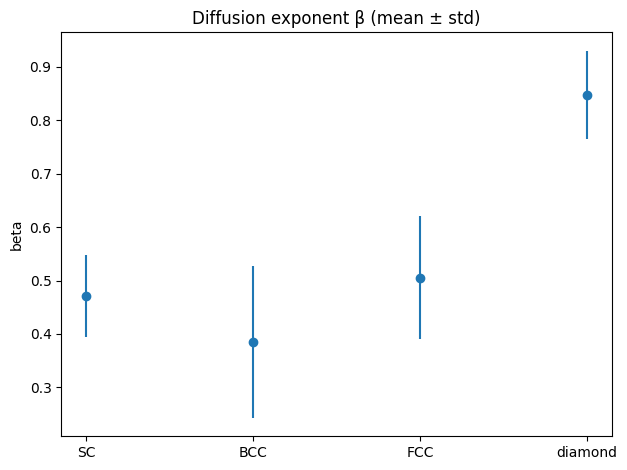

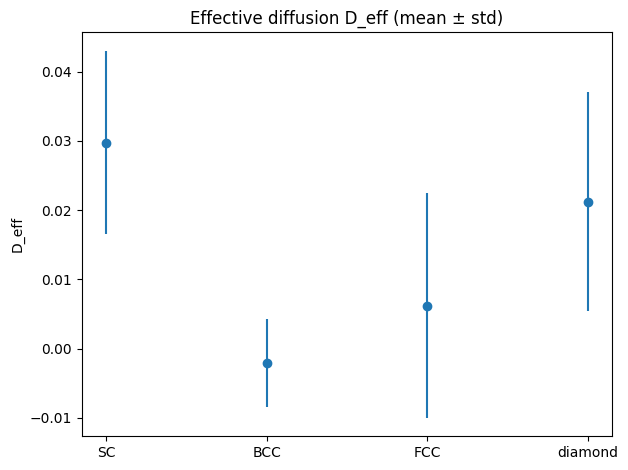

In [22]:
plt.figure()
plt.errorbar(df["lattice"], df["beta_mean"], yerr=df["beta_std"], fmt="o")
plt.ylabel("beta")
plt.title("Diffusion exponent β (mean ± std)")
plt.tight_layout()
plt.show()

plt.figure()
plt.errorbar(df["lattice"], df["Deff_mean"], yerr=df["Deff_std"], fmt="o")
plt.ylabel("D_eff")
plt.title("Effective diffusion D_eff (mean ± std)")
plt.tight_layout()
plt.show()

In [23]:
lattices = ["SC","BCC","FCC","diamond"]


def targets_from_npz(path):
    d = np.load(path)
    t = d["t_bins"]; msd = d["msd_vs_time"]
    L = min(len(t), len(msd))
    t = t[:L]; msd = msd[:L]
    return fit_beta(t, msd), estimate_Deff(t, msd, dim=3, tail_fraction=0.3)

# --- feature extraction per run ---
def features_for_run(lat, size, prob, nearest_neighbor=True, A=1.0, alpha=6.0, a=1.0):
    # Rebuild a representative coords realization for this lattice/spec.
    # (We can’t recover the exact coords from the summary file because coords weren’t saved.)
    coords, _ = build_lattice(lattice_type=lat, a=a, size=size, prob=prob)

    spec = GraphSpec(
        lattice_type=lat,
        size=int(size),
        a=float(a),
        prob=float(prob),
        nearest_neighbor=bool(nearest_neighbor),
        A=float(A),
        alpha=float(alpha),
        t_max=None
    )

    phi, names = build_structured_features(spec, coords=coords, W=None)  # coords-only adds N_nodes
    return phi, names

# Build per-run dataset
rows = []
X_list = []
names_ref = None

for lat in lattices:
    paths = sorted(glob.glob(os.path.join(folder, f"rw_summary_{lat}_run*.npz")))
    for p in paths:
        d = np.load(p)
        size = int(d["size"])
        prob = float(d["prob"])

        beta, Deff = targets_from_npz(p)
        phi, names = features_for_run(lat, size=size, prob=prob, nearest_neighbor=True, A=1.0, alpha=6.0, a=1.0)

        if names_ref is None:
            names_ref = names
        else:
            assert names == names_ref, "Feature-name mismatch across runs."

        X_list.append(phi)
        rows.append({"lattice": lat, "file": os.path.basename(p), "beta": beta, "Deff": Deff})

X = np.vstack(X_list)
df_run = pd.DataFrame(rows)

print("X shape:", X.shape)
display(df_run.head())


X shape: (20, 12)


,lattice,file,beta,Deff
0,SC,rw_summary_SC_run00.npz,0.511761,0.014165
1,SC,rw_summary_SC_run01.npz,0.418564,0.017524
2,SC,rw_summary_SC_run02.npz,0.559318,0.042392
3,SC,rw_summary_SC_run03.npz,0.368735,0.033195
4,SC,rw_summary_SC_run04.npz,0.497792,0.041575


# Reconstruction + Interpretation 

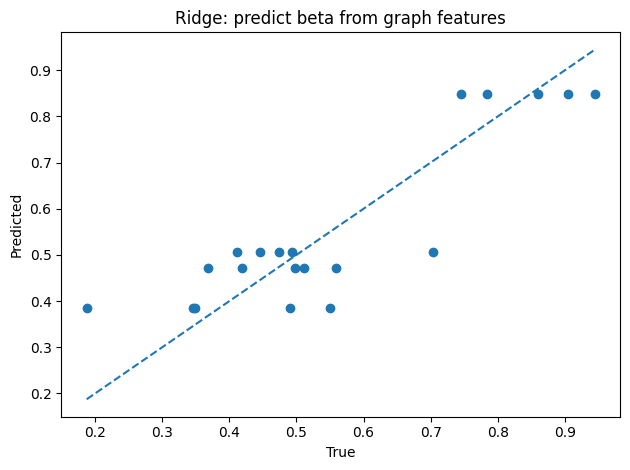

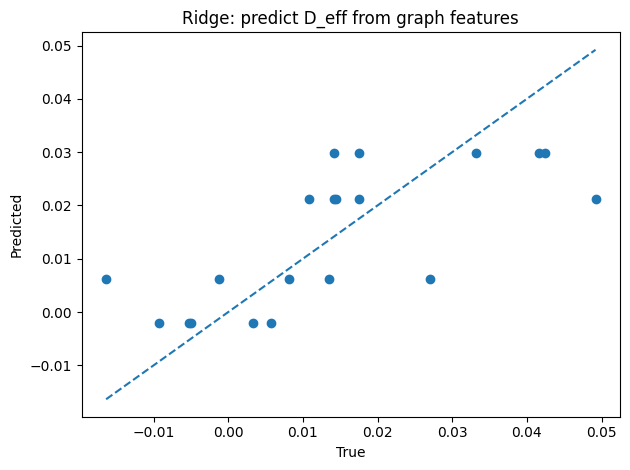

Top beta predictors:
         intercept  w= 0.5522
         z_N_nodes  w= 0.05532
 z_lattice_diamond  w= 0.05318
            z_prob  w= 0.04811
     z_lattice_BCC  w=-0.03984
      z_lattice_SC  w=-0.02074
     z_lattice_FCC  w= 0.007398
            z_size  w= 0

Top Deff predictors:
         intercept  w= 0.01378
      z_lattice_SC  w= 0.006912
     z_lattice_BCC  w=-0.005541
            z_prob  w= 0.003388
     z_lattice_FCC  w=-0.001976
 z_lattice_diamond  w= 0.0006056
         z_N_nodes  w= 0.0003551
            z_size  w= 0


In [24]:
def ridge_fit_predict(X, y, lam=1e-2):
    
    X_mean = X.mean(axis=0)
    X_std = X.std(axis=0) + 1e-12
    Xs = (X - X_mean) / X_std

    
    Xd = np.column_stack([np.ones(Xs.shape[0]), Xs])

    
    I = np.eye(Xd.shape[1])
    I[0,0] = 0.0  
    w = np.linalg.solve(Xd.T @ Xd + lam * I, Xd.T @ y)

    yhat = Xd @ w
    return yhat, w, X_mean, X_std

def plot_pred_vs_true(y, yhat, title):
    plt.figure()
    plt.scatter(y, yhat)
    mn = min(y.min(), yhat.min())
    mx = max(y.max(), yhat.max())
    plt.plot([mn, mx], [mn, mx], linestyle="--")
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.tight_layout()
    plt.show()

y_beta = df_run["beta"].to_numpy()
y_Deff = df_run["Deff"].to_numpy()

beta_hat, w_beta, Xm, Xs = ridge_fit_predict(X, y_beta, lam=1e-2)
Deff_hat, w_Deff, _, _ = ridge_fit_predict(X, y_Deff, lam=1e-2)

plot_pred_vs_true(y_beta, beta_hat, "Ridge: predict beta from graph features")
plot_pred_vs_true(y_Deff, Deff_hat, "Ridge: predict D_eff from graph features")

# Showing the biggest coefficients 
coef_names = ["intercept"] + [f"z_{n}" for n in names_ref]
w_beta_abs = np.abs(w_beta)
top = np.argsort(-w_beta_abs)[:8]
print("Top beta predictors:")
for j in top:
    print(f"{coef_names[j]:>18s}  w={w_beta[j]: .4g}")

w_Deff_abs = np.abs(w_Deff)
top = np.argsort(-w_Deff_abs)[:8]
print("\nTop Deff predictors:")
for j in top:
    print(f"{coef_names[j]:>18s}  w={w_Deff[j]: .4g}")

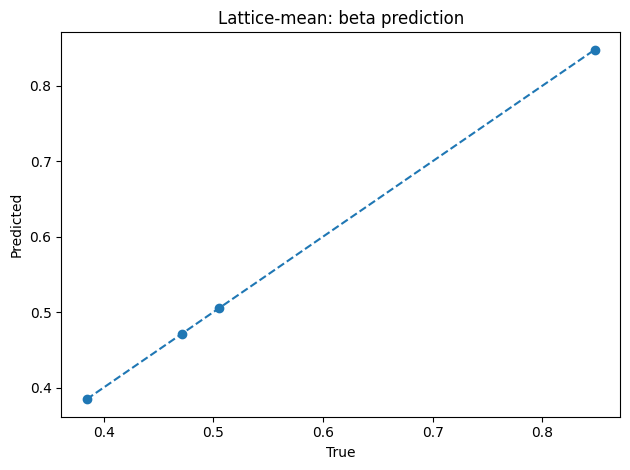

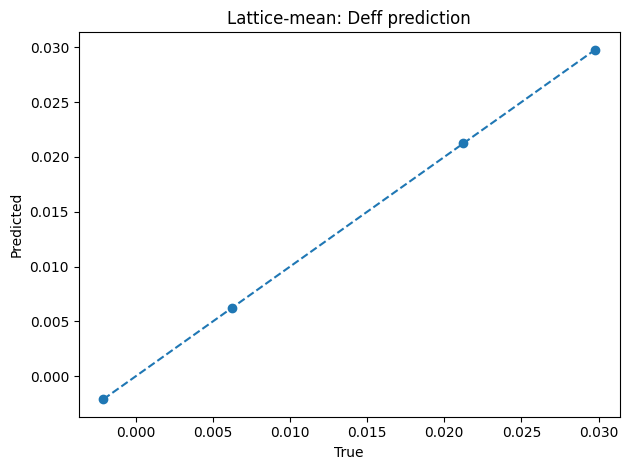

,lattice,beta_mean,beta_std,Deff_mean,Deff_std,n
0,BCC,0.384457,0.141843,-0.002098,0.006315,5
1,FCC,0.505466,0.114626,0.006213,0.016226,5
2,SC,0.471234,0.076464,0.029770,0.013265,5
3,diamond,0.847767,0.082763,0.021232,0.015814,5


In [25]:
# average targets per lattice
df_lat = df_run.groupby("lattice").agg(
    beta_mean=("beta","mean"),
    beta_std=("beta","std"),
    Deff_mean=("Deff","mean"),
    Deff_std=("Deff","std"),
    n=("beta","count")
).reset_index()

# average features per lattice 
X_lat = []
for lat in lattices:
    idx = (df_run["lattice"] == lat).to_numpy()
    X_lat.append(X[idx].mean(axis=0))
X_lat = np.vstack(X_lat)

# fit ridge on lattice-means (4 points only, so interpret cautiously)
beta_hat_lat, w_beta_lat, *_ = ridge_fit_predict(X_lat, df_lat["beta_mean"].to_numpy(), lam=1e-6)
Deff_hat_lat, w_Deff_lat, *_ = ridge_fit_predict(X_lat, df_lat["Deff_mean"].to_numpy(), lam=1e-6)

plot_pred_vs_true(df_lat["beta_mean"].to_numpy(), beta_hat_lat, "Lattice-mean: beta prediction")
plot_pred_vs_true(df_lat["Deff_mean"].to_numpy(), Deff_hat_lat, "Lattice-mean: Deff prediction")

display(df_lat)


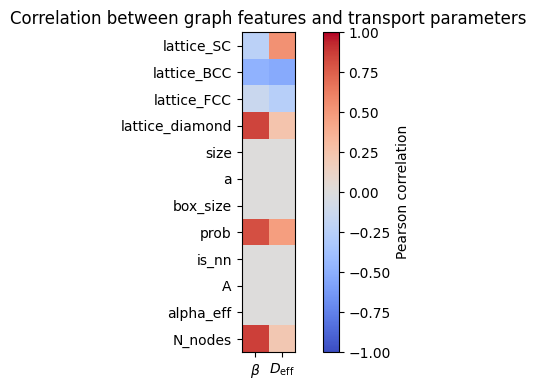

In [30]:
# X: (n_samples, n_features)
# df_run: contains 'beta' and 'Deff'
# names_ref: feature names (length = n_features)

Y = np.column_stack([
    df_run["beta"].to_numpy(),
    df_run["Deff"].to_numpy()
])

target_names = ['$\\beta $', '$D_{\\mathrm{eff}}$']

corr = np.zeros((X.shape[1], Y.shape[1]))

for i in range(X.shape[1]):
    for j in range(Y.shape[1]):
        xi = X[:, i]
        yj = Y[:, j]
        
        if np.std(xi) == 0 or np.std(yj) == 0:
            corr[i, j] = 0.0
        else:
            corr[i, j] = np.corrcoef(xi, yj)[0, 1]


plt.figure(figsize=(6, 4))
im = plt.imshow(corr, vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar(im, label="Pearson correlation")
plt.xticks(range(len(target_names)), target_names)
plt.yticks(range(len(names_ref)), names_ref)
plt.title("Correlation between graph features and transport parameters")
plt.tight_layout()
plt.show()
